# **Amazon Sales Report**

### Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [20]:
df = pd.read_csv(r'D:\Innobyte Services Internship\Amazon Sale Report.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(5))

Shape: (128976, 21)
Columns: ['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel', 'ship-service-level', 'Category', 'Size', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'B2B', 'fulfilled-by', 'New', 'PendingS']
   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel ship-service-level  Category Size Courier Status  \
0   Merchant     Amazon.in           Standard   T-shirt    S     On the Way   
1   Merchant     Amazon.in           Standard     Shirt  3XL        Shipped   
2     Amazon     Amazon.in    

### Clean Dataset

In [21]:
# Drop fully empty columns
df = df.dropna(axis=1, how='all')

# Drop useless null-heavy columns
df = df.drop(columns=['currency'], errors='ignore')

In [30]:
# Remove duplicates
df = df.drop_duplicates(subset=["Order ID"], keep="first")
print(df.shape)

(120229, 21)


In [31]:
#Date cleaning
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(df.shape)

(120229, 21)


### Fill missing values

In [28]:

# Text columns (Category / State / City / Status)
for col in ['Category', 'ship-state', 'ship-city', 'Status']:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Numeric columns (Amount, Qty)
for col in ['Amount', 'Qty']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Fill ship-postal-code and ship-country
if 'ship-postal-code' in df.columns:
    df['ship-postal-code'] = df['ship-postal-code'].fillna("Unknown")

if 'ship-country' in df.columns:
    df['ship-country'] = df['ship-country'].fillna("Unknown")

if 'fulfilled-by' in df.columns:
    df['fulfilled-by']=df['fulfilled-by'].fillna("Other")


In [27]:
print(df.shape)
print("After Cleaning null values:", df.isnull().sum())

(120229, 21)
After Cleaning null values: index                 0
Order ID              0
Date                  0
Status                0
Fulfilment            0
Sales Channel         0
ship-service-level    0
Category              0
Size                  0
Courier Status        0
Qty                   0
Amount                0
ship-city             0
ship-state            0
ship-postal-code      0
ship-country          0
B2B                   0
fulfilled-by          0
Year                  0
Month                 0
Order_Month           0
dtype: int64


### Feature engineering

In [26]:
# Check sample values
print(df['Date'].head(10))

# Convert to datetime 
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], format="%m-%d-%y", errors='coerce')

# Drop rows where NaT 
df = df.dropna(subset=['Date'])

df.loc[:, 'Year'] = df['Date'].dt.year
df.loc[:, 'Month'] = df['Date'].dt.month
df.loc[:, 'Order_Month'] = df['Date'].dt.to_period('M').astype(str)

print(df[['Date','Year','Month','Order_Month']].head())


0   2022-04-30
1   2022-04-30
2   2022-04-30
3   2022-04-30
4   2022-04-30
5   2022-04-30
6   2022-04-30
7   2022-04-30
8   2022-04-30
9   2022-04-30
Name: Date, dtype: datetime64[ns]
        Date  Year  Month Order_Month
0 2022-04-30  2022      4     2022-04
1 2022-04-30  2022      4     2022-04
2 2022-04-30  2022      4     2022-04
3 2022-04-30  2022      4     2022-04
4 2022-04-30  2022      4     2022-04


### Sales Overview : 

Total Revenue: 73323468.87
Total Orders: 120229
Total Units Sold: 108637
Average Order Value: 609.8650813863544


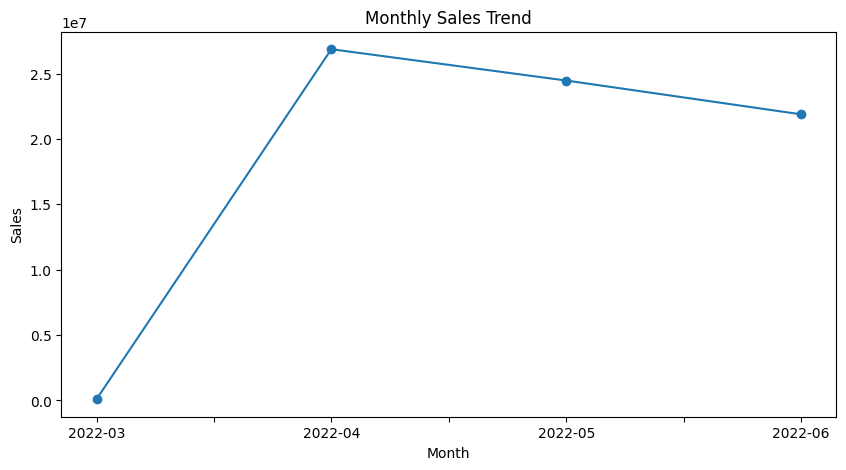

In [32]:
# Total Revenue, Orders, Units
total_revenue = df['Amount'].sum()
total_orders = df['Order ID'].nunique()
total_units = df['Qty'].sum()
aov = df.groupby('Order ID')['Amount'].sum().mean()

print("Total Revenue:", total_revenue)
print("Total Orders:", total_orders)
print("Total Units Sold:", total_units)
print("Average Order Value:", aov)

# Monthly Sales Trend
monthly_sales = df.groupby('Order_Month')['Amount'].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()


### Product Analysis:

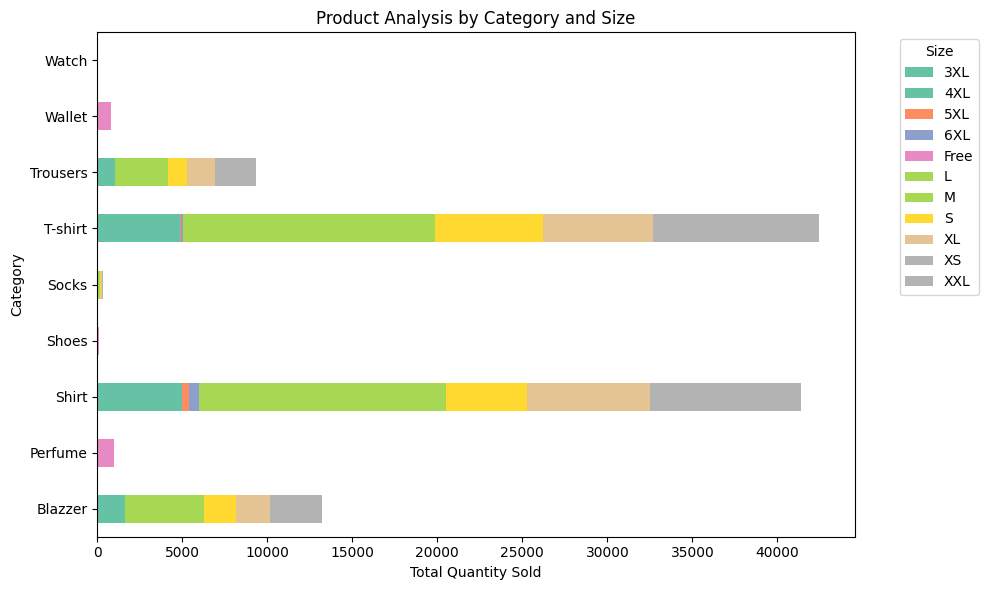

In [33]:
# Aggregate Quantity by Category and Size
summary = df.groupby(['Category', 'Size'])['Qty'].sum().unstack(fill_value=0)

# Plot stacked horizontal bar chart
summary.plot(kind='barh', stacked=True, figsize=(10,6), colormap='Set2')

plt.xlabel('Total Quantity Sold')
plt.ylabel('Category')
plt.title('Product Analysis by Category and Size')
plt.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

###  Fulfillment Analysis

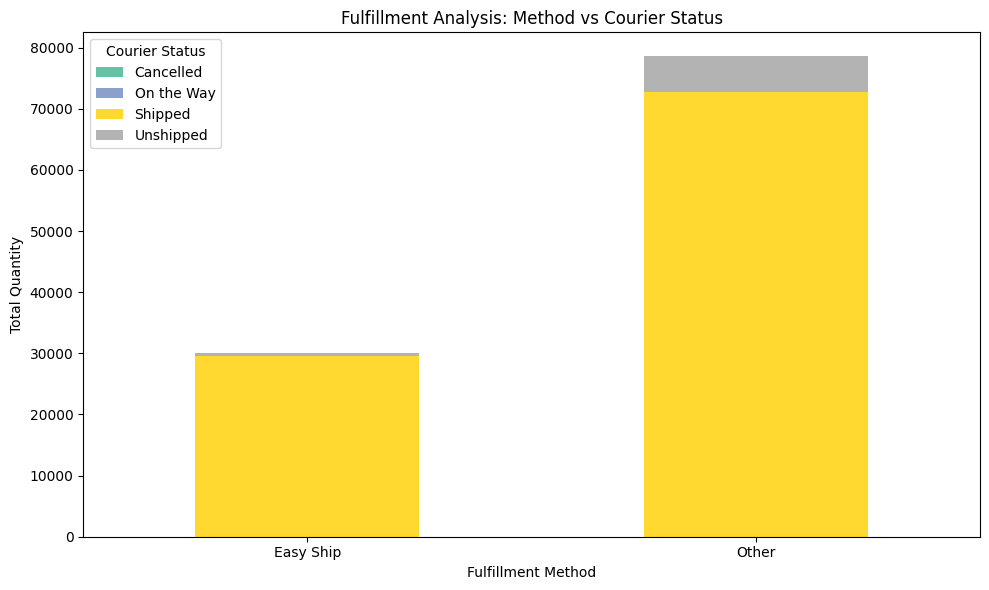

In [34]:
# Group by fulfillment method & courier status
fulfillment_status = df.groupby(['fulfilled-by', 'Courier Status'])['Qty'].sum().unstack(fill_value=0)

# Plot stacked bar chart
fulfillment_status.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')

plt.title('Fulfillment Analysis: Method vs Courier Status')
plt.xlabel('Fulfillment Method')
plt.ylabel('Total Quantity')
plt.xticks(rotation=360)
plt.legend(title='Courier Status')
plt.tight_layout()
plt.show()

### Customer Segmentaion

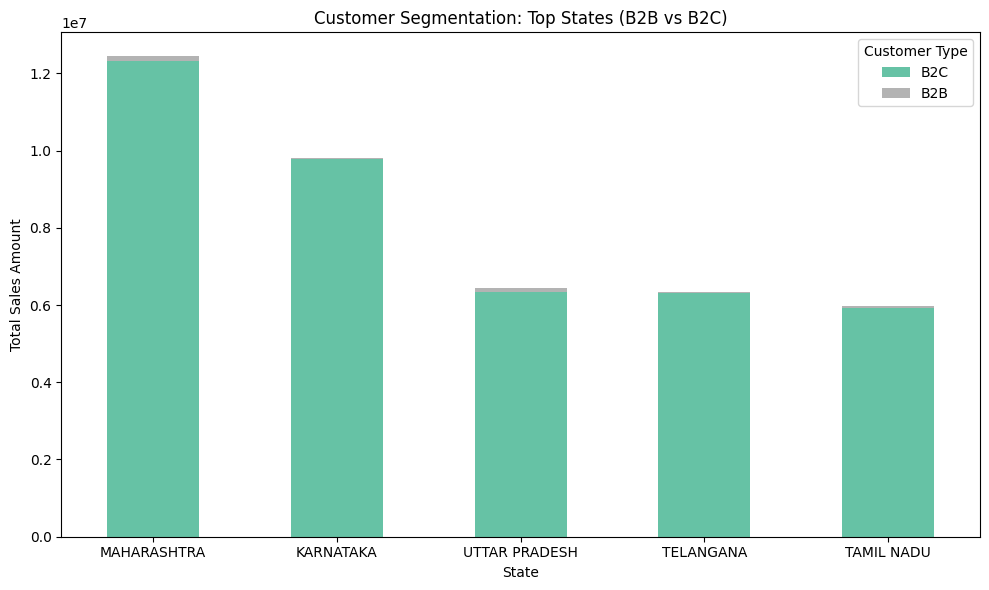

In [35]:
# Aggregate sales by State and B2B/B2C
segmentation = df.groupby(["ship-state", "B2B"])["Amount"].sum().unstack(fill_value=0)

# Select top 5 states by total sales
top_states = segmentation.sum(axis=1).sort_values(ascending=False).head(5).index
segmentation = segmentation.loc[top_states]

# Plot stacked bar chart
segmentation.plot( kind="bar", stacked=True,figsize=(10,6),colormap="Set2")

plt.title("Customer Segmentation: Top States (B2B vs B2C)")
plt.xlabel("State")
plt.ylabel("Total Sales Amount")
plt.xticks(rotation=360)
plt.legend(title="Customer Type", labels=["B2C","B2B"])
plt.tight_layout()
plt.show()

###  Geographical Analysis

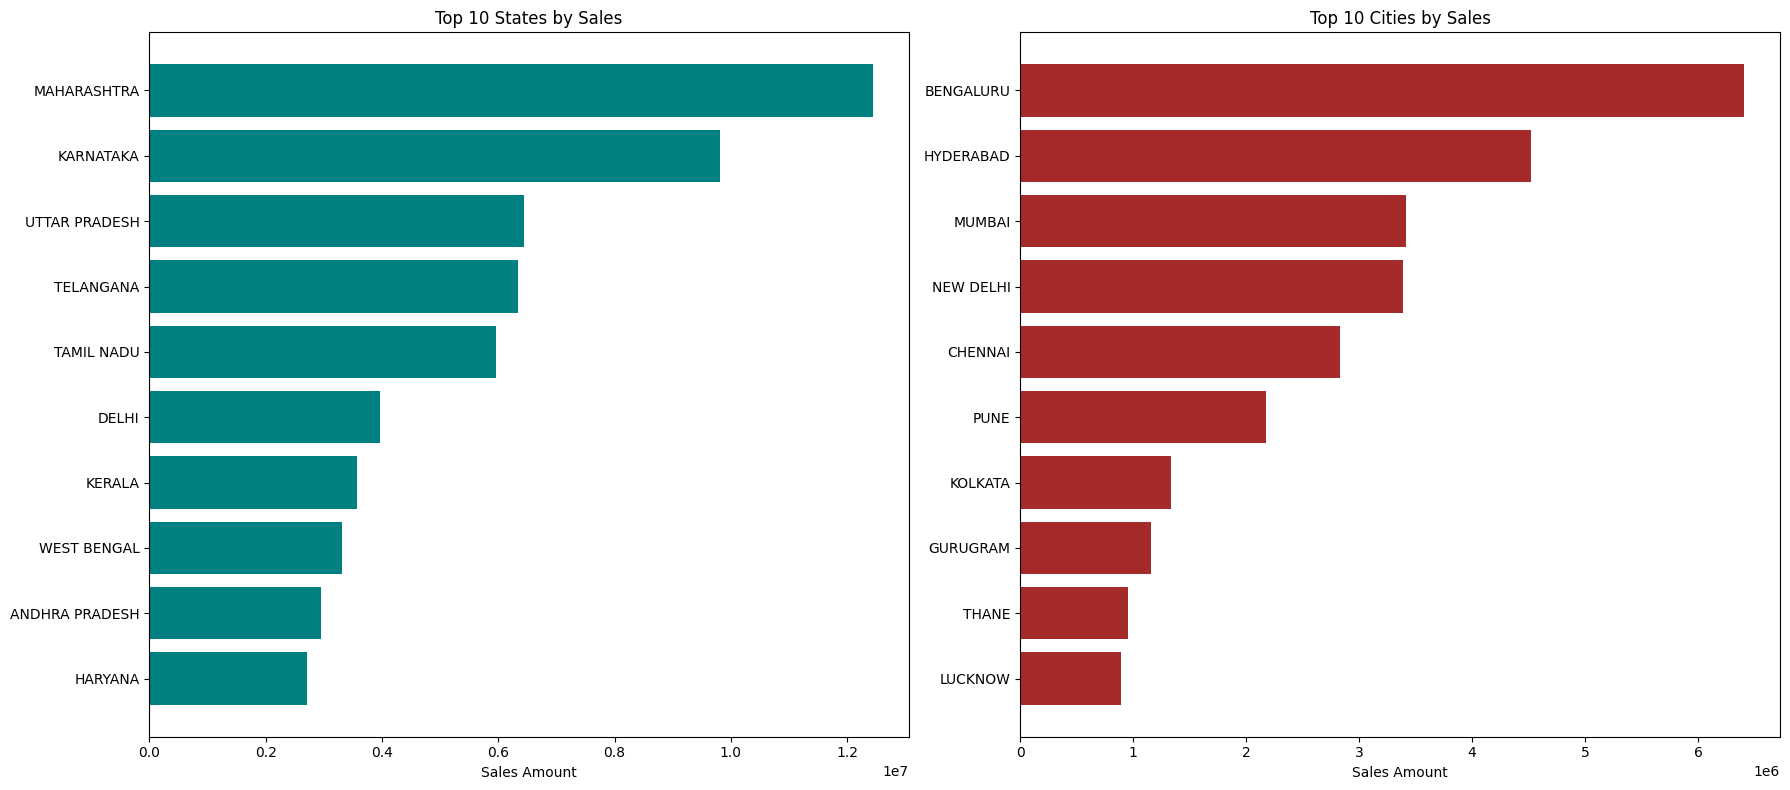

In [36]:
# Aggregate sales by State and City
state_sales = df.groupby("ship-state")["Amount"].sum().sort_values(ascending=False).head(10)
city_sales = df.groupby("ship-city")["Amount"].sum().sort_values(ascending=False).head(10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(18,8))

# Top 10 States by Sales
axs[0].barh(state_sales.index, state_sales.values, color="teal")
axs[0].set_title("Top 10 States by Sales")
axs[0].set_xlabel("Sales Amount")
axs[0].invert_yaxis()


# Top 10 Cities by Sales
axs[1].barh(city_sales.index, city_sales.values, color="brown")
axs[1].set_title("Top 10 Cities by Sales")
axs[1].set_xlabel("Sales Amount")
axs[1].invert_yaxis()


plt.tight_layout()
plt.show()